In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

In [19]:
# Load data
data = pd.read_csv('/content/Electric_Production.csv')
data.set_index('DATE', inplace=True)
data.index = pd.to_datetime(data.index)

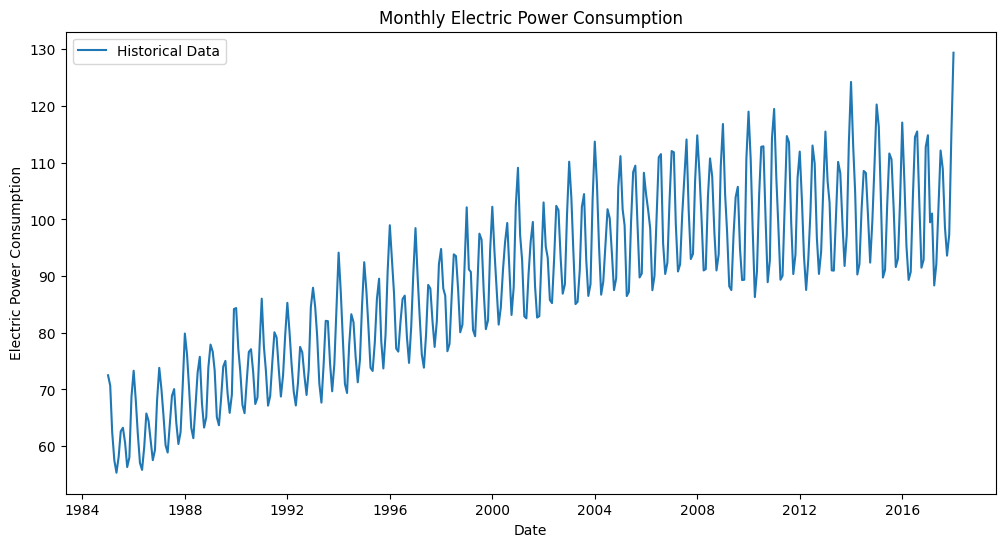

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Value'], label='Historical Data')
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.title('Monthly Electric Power Consumption')
plt.legend()
plt.show()

In [21]:
# Scale data to fit within 0 and 1 for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Value'].values.reshape(-1, 1))

In [22]:
# Prepare data for LSTM model
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [23]:
# Prepare data for training
X, y = create_sequences(scaled_data, 12)  # Use a fixed sequence length
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [25]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step
        return out

In [26]:
# Function to train the model
def train_model(hidden_size, num_layers, batch_size, num_epochs=50):
    model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i + batch_size]
            y_batch = y_train_tensor[i:i + batch_size]

            # Forward pass
            outputs = model(X_batch)  # Remove unsqueeze(-1) here
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

In [27]:
# Grid search for hyperparameters
param_grid = {
    'hidden_size': [50, 75, 100],
    'num_layers': [1, 2, 3],
    'batch_size': [12, 24, 32],
    'num_epochs': [50]
}

# Store results
results = []

In [28]:
for params in ParameterGrid(param_grid):
    print(f'Training model with params: {params}')
    model = train_model(hidden_size=params['hidden_size'],
                        num_layers=params['num_layers'],
                        batch_size=params['batch_size'],
                        num_epochs=params['num_epochs'])

    # Evaluate the model
    model.eval()
    with torch.no_grad():
      test_pred = model(X_test_tensor)  # Ensure input has correct dimensions
      test_pred = scaler.inverse_transform(test_pred.numpy())
      y_test_actual = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))


    # Calculate Test MSE
    test_mse = mean_squared_error(y_test_actual, test_pred)
    results.append((params, test_mse))
    print(f'Test MSE: {test_mse:.4f}')

Training model with params: {'batch_size': 12, 'hidden_size': 50, 'num_epochs': 50, 'num_layers': 1}
Test MSE: 15.4399
Training model with params: {'batch_size': 12, 'hidden_size': 50, 'num_epochs': 50, 'num_layers': 2}
Test MSE: 13.3968
Training model with params: {'batch_size': 12, 'hidden_size': 50, 'num_epochs': 50, 'num_layers': 3}
Test MSE: 34.4438
Training model with params: {'batch_size': 12, 'hidden_size': 75, 'num_epochs': 50, 'num_layers': 1}
Test MSE: 15.2270
Training model with params: {'batch_size': 12, 'hidden_size': 75, 'num_epochs': 50, 'num_layers': 2}
Test MSE: 13.6593
Training model with params: {'batch_size': 12, 'hidden_size': 75, 'num_epochs': 50, 'num_layers': 3}
Test MSE: 25.3172
Training model with params: {'batch_size': 12, 'hidden_size': 100, 'num_epochs': 50, 'num_layers': 1}
Test MSE: 11.6244
Training model with params: {'batch_size': 12, 'hidden_size': 100, 'num_epochs': 50, 'num_layers': 2}
Test MSE: 11.0539
Training model with params: {'batch_size': 12,

In [29]:
# Find the best hyperparameters
best_params, best_mse = min(results, key=lambda x: x[1])
print(f'Best params: {best_params}, Best MSE: {best_mse:.4f}')

Best params: {'batch_size': 12, 'hidden_size': 100, 'num_epochs': 50, 'num_layers': 2}, Best MSE: 11.0539


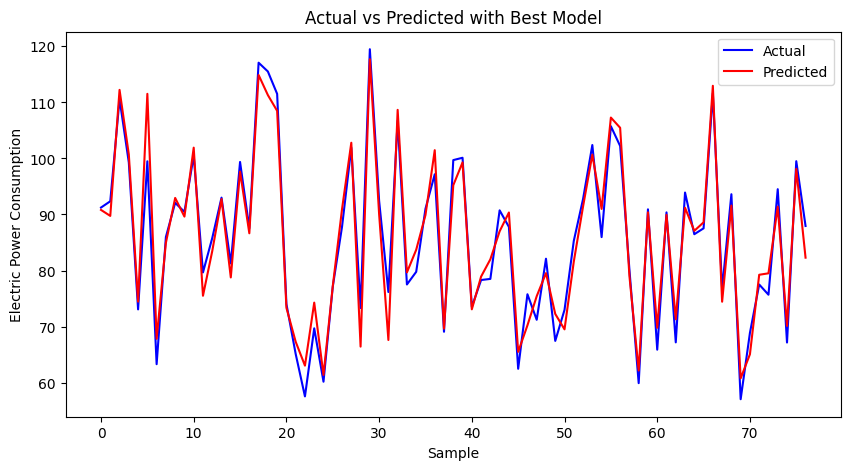

In [30]:
# Plot actual vs predicted for the best model
best_model = train_model(hidden_size=best_params['hidden_size'],
                         num_layers=best_params['num_layers'],
                         batch_size=best_params['batch_size'],
                         num_epochs=best_params['num_epochs'])

best_model.eval()
with torch.no_grad():
    # Remove the unsqueeze(-1) here
    test_pred_best = best_model(X_test_tensor)
    test_pred_best = scaler.inverse_transform(test_pred_best.numpy())
    y_test_actual_best = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual_best, label='Actual', color='blue')
plt.plot(test_pred_best, label='Predicted', color='red')
plt.title('Actual vs Predicted with Best Model')
plt.xlabel('Sample')
plt.ylabel('Electric Power Consumption')
plt.legend()
plt.show()


In [31]:
def forecast_future_months(model, last_sequence, n_months, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_months):
        # Reshape to (1, seq_length, input_size)
        current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)  # Add batch and feature dimensions
        print(f"Input shape for LSTM: {current_sequence_tensor.shape}")  # Check the shape here

        next_pred = model(current_sequence_tensor)
        future_predictions.append(next_pred.item())

        # Update the sequence for the next iteration
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred.item()  # Add the prediction to the sequence

    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


In [32]:
# Get the last sequence from our scaled data
last_sequence = scaled_data[-12:]

# Forecast next 24 months
n_future_months = 24
forecasted_values = forecast_future_months(best_model, last_sequence, n_future_months, scaler)

# Create future dates for plotting
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_future_months, freq='MS')

Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shape for LSTM: torch.Size([1, 12, 1])
Input shap

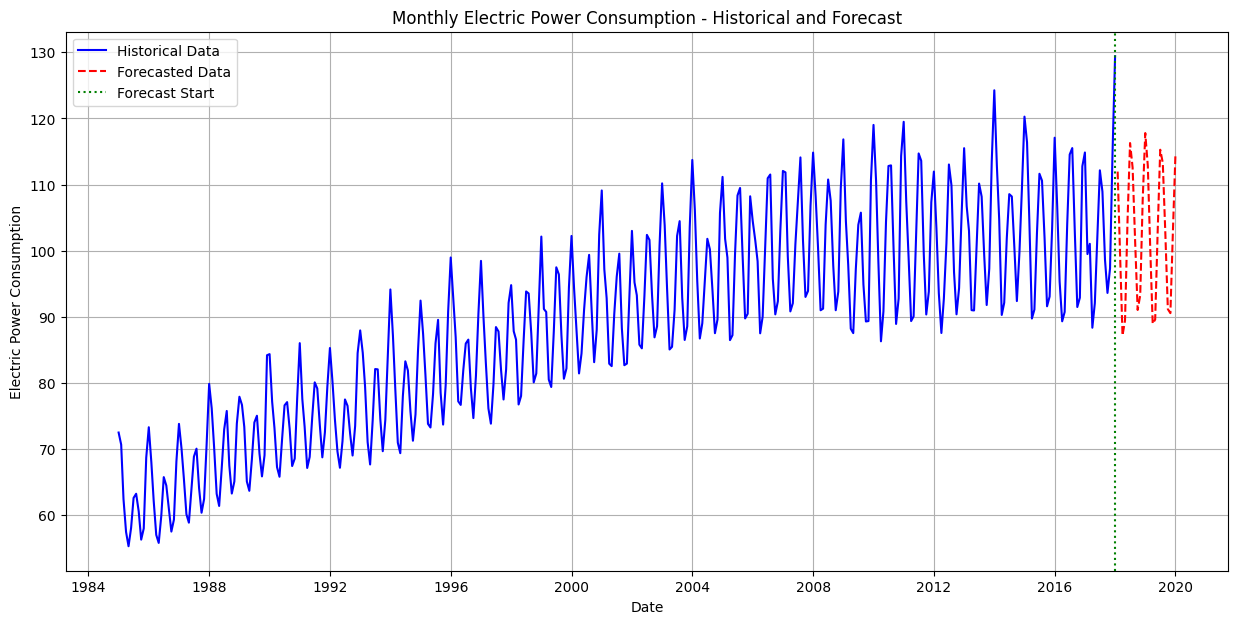

In [33]:
# Plot historical and forecasted values
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['Value'], label='Historical Data', color='blue')
plt.plot(future_dates, forecasted_values, label='Forecasted Data', color='red', linestyle='--')
plt.axvline(x=last_date, color='green', linestyle=':', label='Forecast Start')
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.title('Monthly Electric Power Consumption - Historical and Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Print forecast summary
print("\nForecast Summary:")
print(f"Historical data range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
print(f"Forecast range: {future_dates[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")
print(f"Number of months forecasted: {n_future_months}")


Forecast Summary:
Historical data range: 1985-01-01 to 2018-01-01
Forecast range: 2018-02-01 to 2020-01-01
Number of months forecasted: 24
